In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns

In [2]:
#sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

# PBMCs

We consider an annotated reference dataset adata_ref and a dataset for which you want to query labels and embeddings adata.

In [3]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

To use `sc.tl.ingest`, the datasets need to be defined on the same variables.

In [4]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

The model and graph (here PCA, neighbors, UMAP) trained on the reference data will explain the biological variation observed within it.

In [5]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The manifold still looks essentially the same as in the [clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


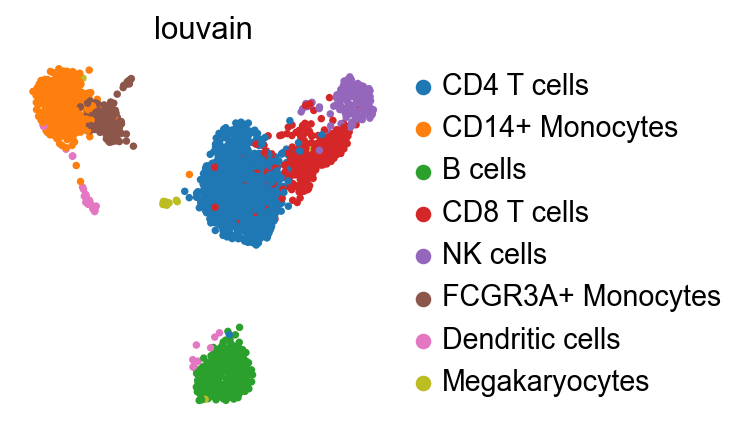

In [6]:
sc.pl.umap(adata_ref, color='louvain')

## Mapping PBMCs using ingest

Let’s map labels and embeddings from `adata_ref` to `adata` based on a chosen representation. Here, we use `adata_ref.obsm['X_pca']` to map cluster labels and the UMAP coordinates.

In [7]:
sc.tl.ingest(adata, adata_ref, obs='louvain')

In [8]:
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


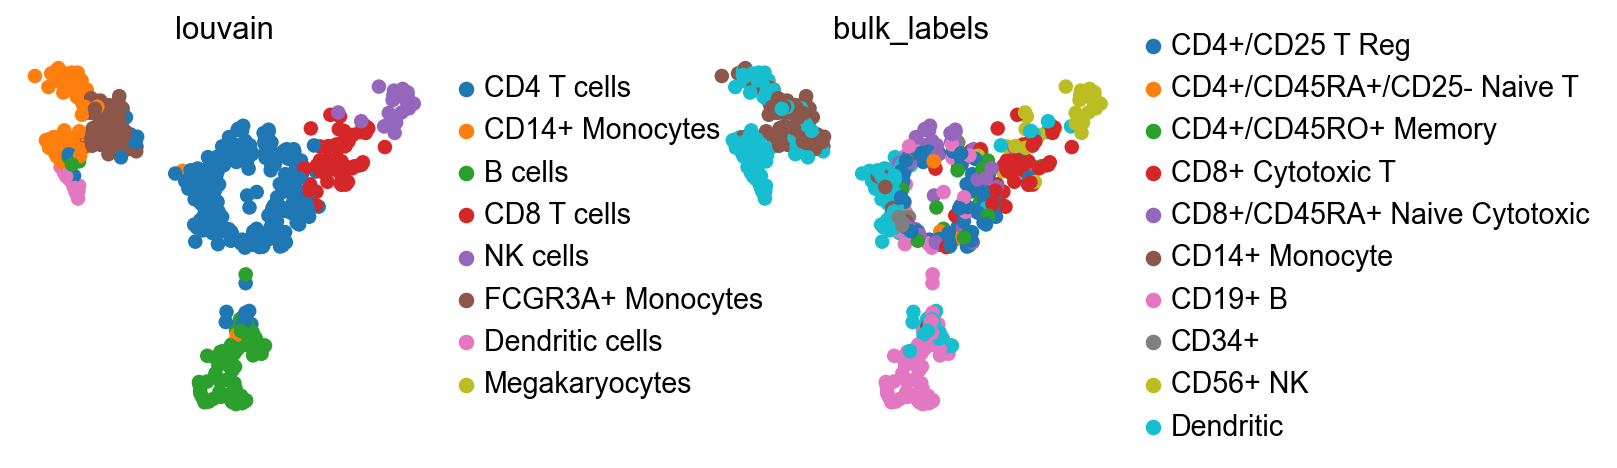

In [9]:
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

By comparing the ‘bulk_labels’ annotation with ‘louvain’, we see that the data has been reasonably mapped, only the annotation of dendritic cells seems ambiguous and might have been ambiiguous in `adata` already.

In [10]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [11]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors

/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_3617/2341824880.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


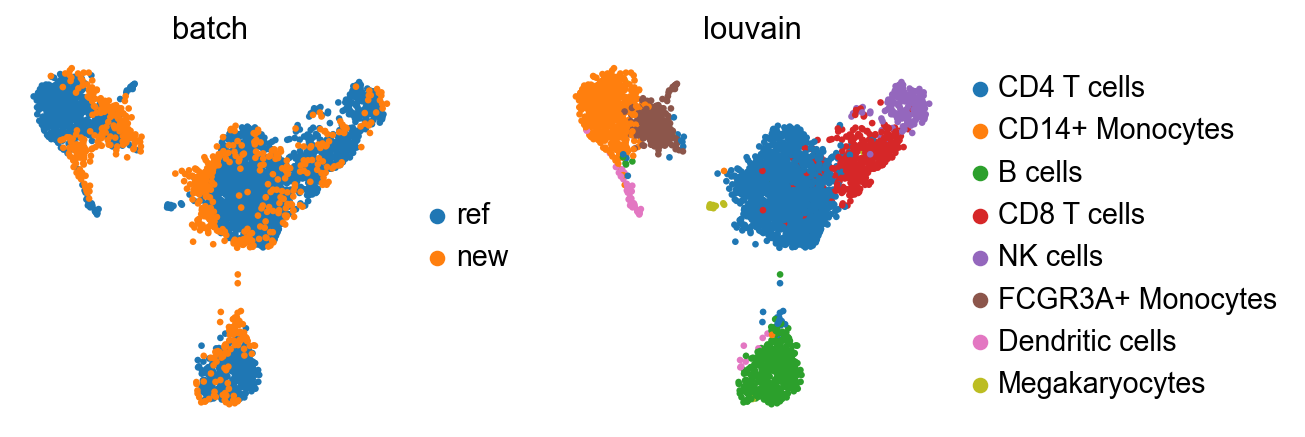

In [12]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

While there seems to be some batch-effect in the monocytes and dendritic cell clusters, the new data is otherwise mapped relatively homogeneously.

The megakaryoctes are only present in `adata_ref` and no cells from `adata` map onto them. If interchanging reference data and query data, Megakaryocytes do not appear as a separate cluster anymore. This is an extreme case as the reference data is very small; but one should always question if the reference data contain enough biological variation to meaningfully accomodate query data.

# Using BBKNN

In [13]:
sc.tl.pca(adata_concat)

In [15]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6

CPU times: user 163 ms, sys: 6.14 ms, total: 170 ms
Wall time: 287 ms


In [16]:
sc.tl.umap(adata_concat)

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


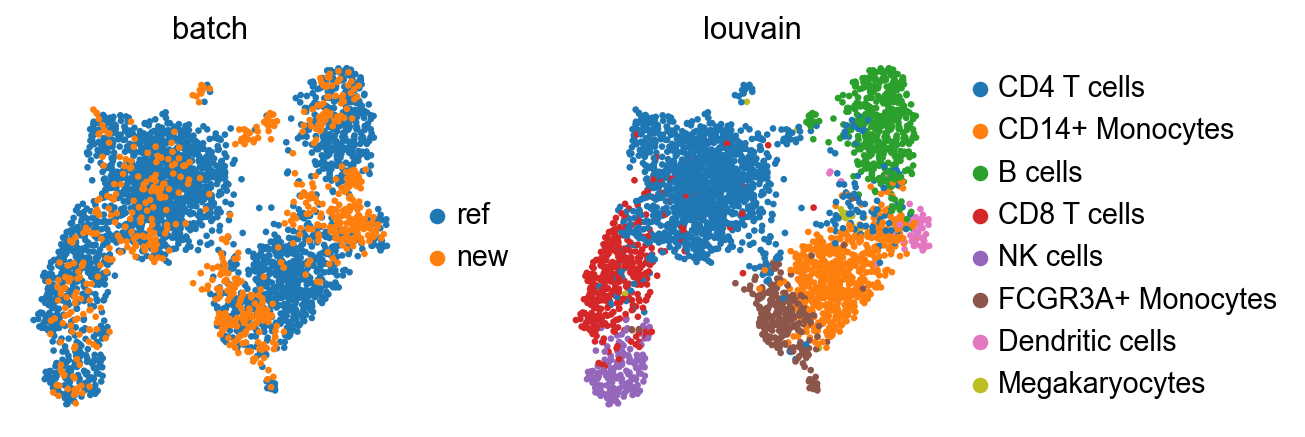

In [17]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

Also BBKNN doesn’t maintain the Megakaryocytes cluster. However, it seems to mix cells more homogeneously.

# Pancreas

The following data has been used in the scGen paper [[Lotfollahi19]](https://doi.org/10.1038/s41592-019-0494-8), has been used [here](https://nbviewer.jupyter.org/github/M0hammadL/scGen_notebooks/blob/master/notebooks/scgen_batch_removal.ipynb), was curated [here](https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/pancreas.ipynb) and can be downloaded from [here (the BBKNN paper)](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip).

It contains data for human pancreas from 4 different studies (Segerstolpe16, Baron16, Wang16, Muraro16), which have been used in the seminal papers on single-cell dataset integration (Butler18, Haghverdi18) and many times ever since.

In [18]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

  0%|          | 0.00/176M [00:00<?, ?B/s]

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [19]:
adata_all.shape

(14693, 2448)

In [20]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

To simplify visualization, let’s remove the 5 minority classes.

In [21]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance
    counts.index[:-5].tolist(), inplace=True)

/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_3617/2673735842.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance


## Seeing the batch effect



In [22]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

We observe a batch effect.

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


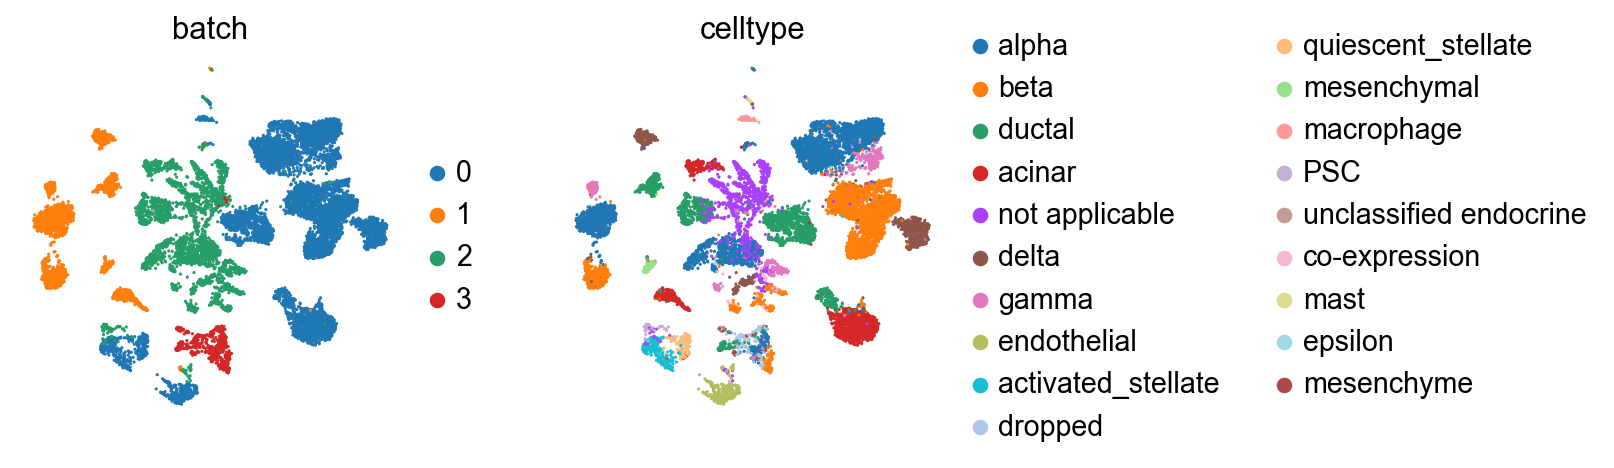

In [23]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

## BBKNN

It can be well-resolved using BBKNN [[Polanski19]](https://doi.org/10.1093/bioinformatics/btz625).

In [26]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

CPU times: user 1.32 s, sys: 13.6 ms, total: 1.33 s
Wall time: 1.23 s


In [27]:
sc.tl.umap(adata_all)

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


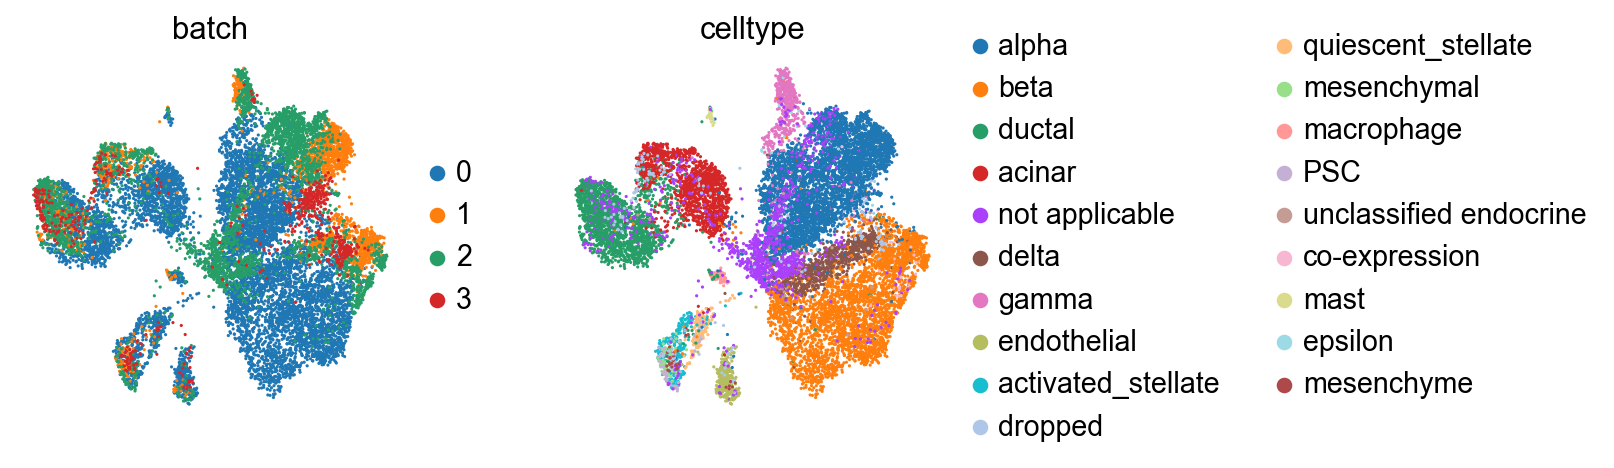

In [28]:
sc.pl.umap(adata_all, color=['batch', 'celltype'])

If one prefers to work more iteratively starting from one reference dataset, one can use ingest.

## Mapping onto a reference batch using ingest

Choose one reference batch for training the model and setting up the neighborhood graph (here, a PCA) and separate out all other batches.

As before, the model trained on the reference batch will explain the biological variation observed within it.

In [29]:
adata_ref = adata_all[adata_all.obs.batch == '0']

In [31]:
# Compute the PCA, neighbors and UMAP on the reference data

sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


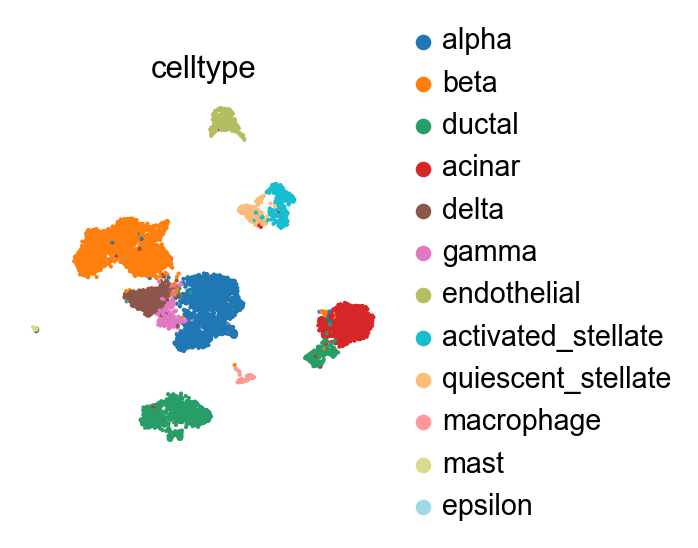

In [32]:
# The reference batch contains 12 to 19 cell types across all batches

sc.pl.umap(adata_ref, color='celltype')

Iteratively map labels (such as ‘celltype’) and embeddings (such as ‘X_pca’ and ‘X_umap’) from the reference data onto the query batches.



In [33]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [34]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs='celltype')

... integrating batch 1
running ingest
    finished (0:00:05)
... integrating batch 2
running ingest
    finished (0:00:07)
... integrating batch 3
running ingest
    finished (0:00:02)


Each of the query batches now carries annotation that has been contextualized with adata_ref. By concatenating, we can view it together.

In [35]:
adata_concat = adata_ref.concatenate(adatas)

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [36]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_3617/1749108536.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering


/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


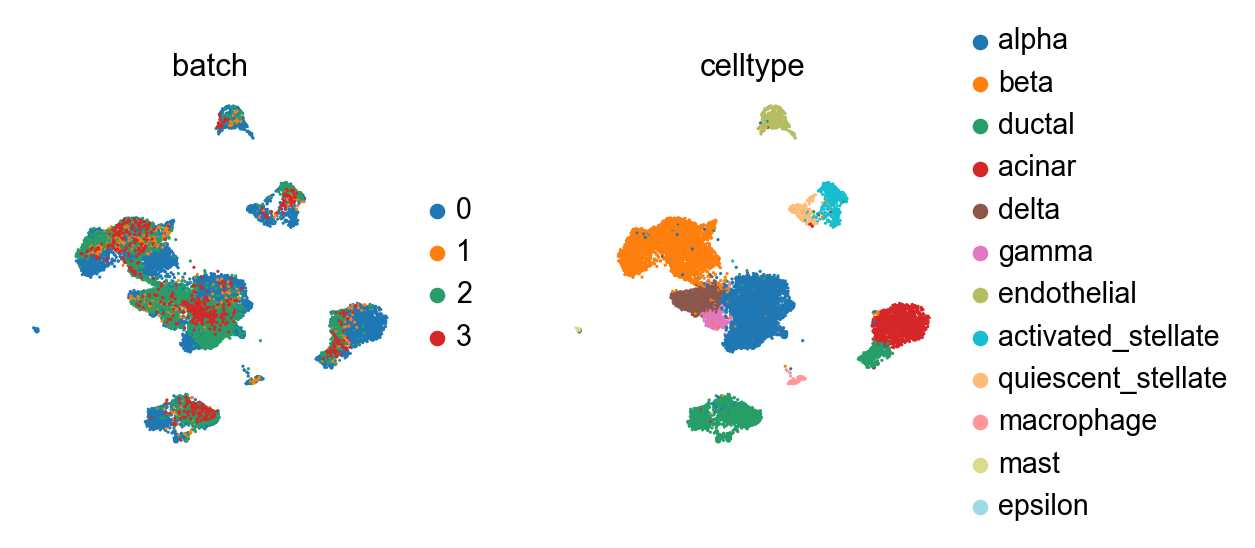

In [37]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])

Compared to the BBKNN result, this is maintained clusters in a much more pronounced fashion. If one already observed a desired continuous structure (as in the hematopoietic datasets, for instance), ingest allows to easily maintain this structure.

## Evaluating consistency

Let us subset the data to the query batches.

In [38]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


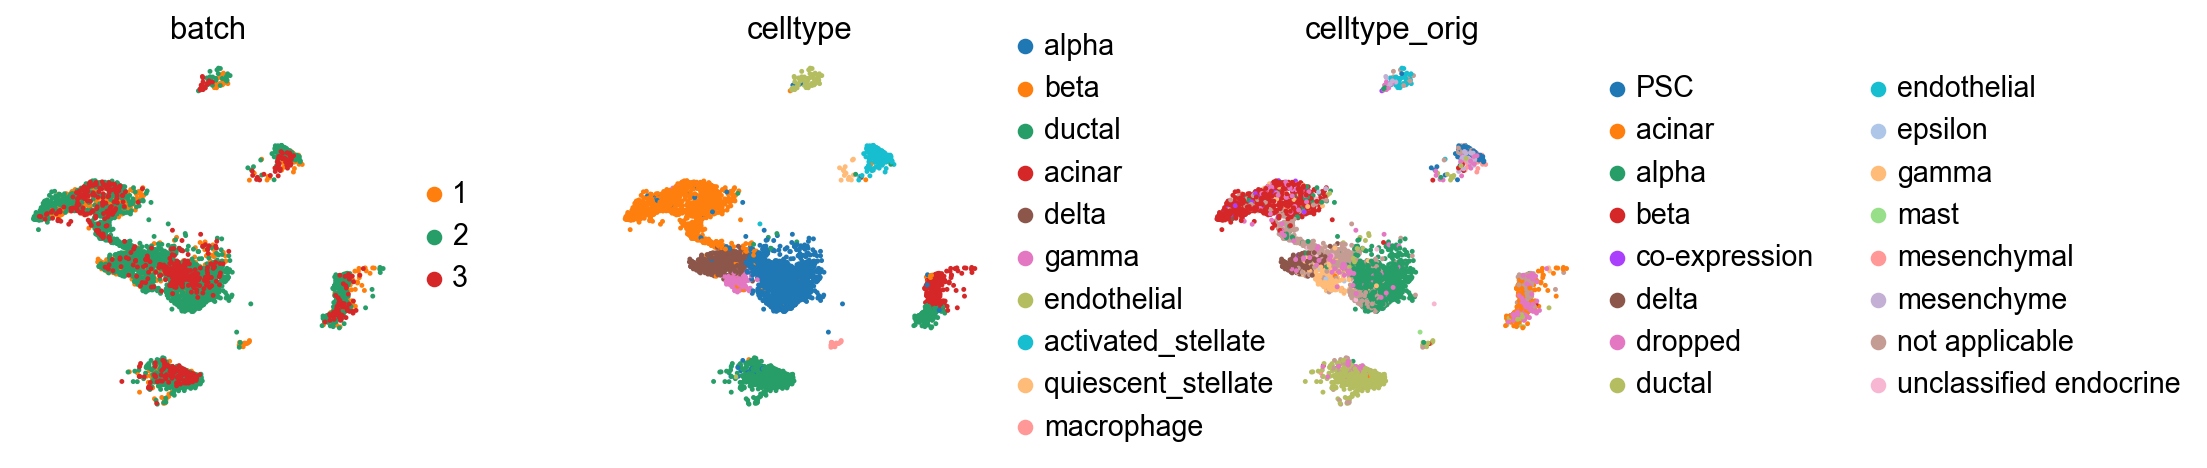

In [39]:
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig'], wspace=0.4)

## Cell types conserved across batches

Let us first focus on cell types that are conserved with the reference, to simplify reading of the confusion matrix.

In [40]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]  # intersect categories
obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering

/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_3617/2750919581.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_3617/2750919581.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_3617/2750919581.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  obs_query_conserved.celltype_orig.cat.reorder_categories(obs

In [44]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial
celltype,,,,,,,
alpha,1815,3,15,0,1,20,0
beta,53,805,5,1,11,36,0
ductal,6,5,684,242,0,0,0
acinar,2,3,3,165,0,3,0
delta,6,3,1,0,304,73,0
gamma,1,5,0,1,0,184,0
endothelial,2,0,0,0,0,0,36


Overall, the conserved cell types are also mapped as expected. The main exception are some acinar cells in the original annotation that appear as acinar cells. However, already the reference data is observed to feature a cluster of both acinar and ductal cells, which explains the discrepancy, and indicates a potential inconsistency in the initial annotation.

## All cell types

Let us now move on to look at all cell types.

In [45]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)

celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
alpha,0,0,1815,3,3,1,39,15,0,3,20,7,0,0,309,10
beta,1,1,53,805,36,11,41,5,0,0,36,0,0,1,522,24
ductal,0,242,6,5,0,0,39,684,0,0,0,0,2,0,96,0
acinar,0,165,2,3,0,0,23,3,0,0,3,0,0,0,90,0
delta,0,0,6,3,0,304,13,1,0,6,73,0,0,0,96,7
gamma,0,1,1,5,0,0,1,0,0,1,184,0,0,0,15,0
endothelial,1,0,2,0,0,0,6,0,36,0,0,0,0,6,7,0
activated_stellate,48,1,1,3,0,0,11,6,0,0,0,0,78,20,17,0
quiescent_stellate,4,0,1,1,0,0,5,1,1,0,0,0,0,0,1,0


We observe that PSC [(pancreatic stellate cells)](https://en.wikipedia.org/wiki/Pancreatic_stellate_cell) cells are in fact just inconsistently annotated and correctly mapped on ‘activated_stellate’ cells.

Also, it’s nice to see that ‘mesenchyme’ and ‘mesenchymal’ cells both map onto the same category. However, that category is again ‘activated_stellate’ and likely incorrect.

## Visualizing distributions across batches

Often, batches correspond to experiments that one wants to compare. Scanpy offers to convenient visualization possibilities for this.

1. a density plot
2. a partial visualization of a subset of categories/groups in an emnbedding

### Density plot

In [46]:
sc.tl.embedding_density(adata_concat, groupby='batch')

computing density on 'umap'


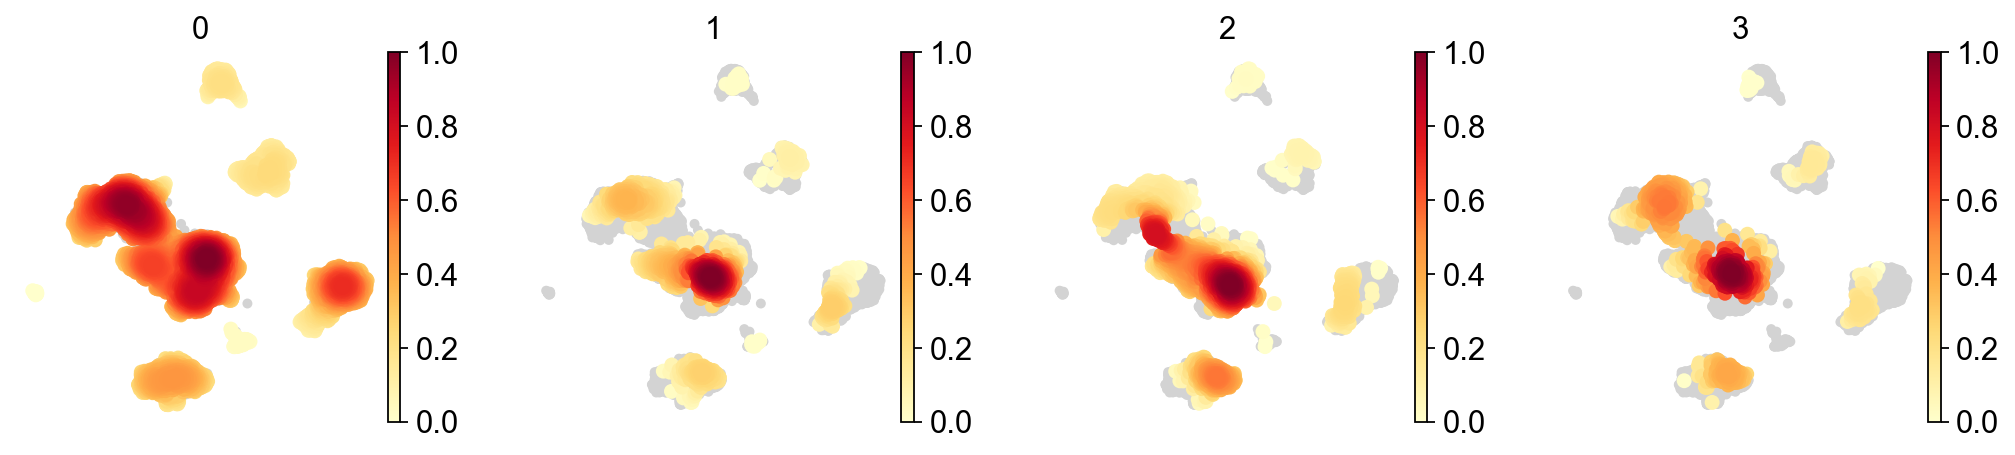

In [47]:
sc.pl.embedding_density(adata_concat, groupby='batch')

### Partial visualizaton of a subset of groups in embedding

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


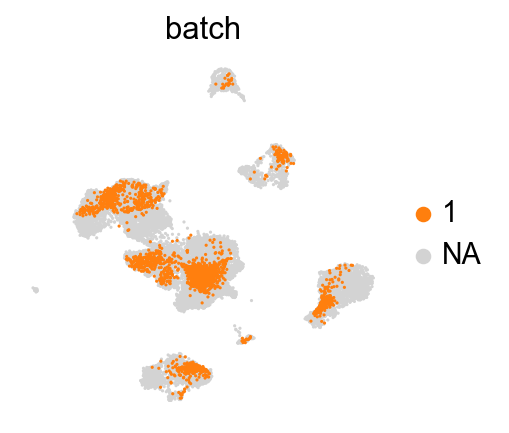

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


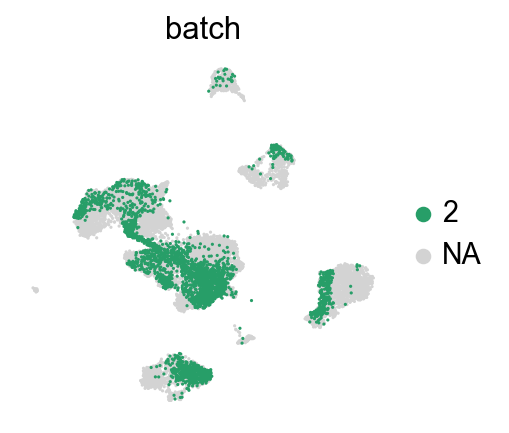

/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/mscavino/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


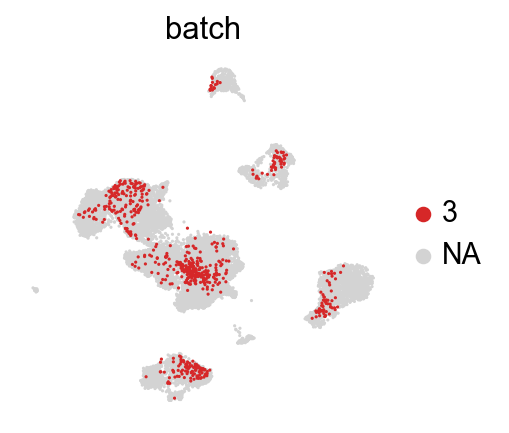

In [48]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])